In [1]:
# We will use the LIAR dataset from this paper: https://aclanthology.org/P17-2067/
# Link https://www.cs.ucsb.edu/~william/data/liar_dataset.zip

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Sequential

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, MaxPooling1D, Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pathlib
auc = tf.keras.metrics.AUC()

from sklearn.model_selection import train_test_split


In [3]:
# Load and see training data
liar_data_train = pd.read_csv(os.path.join(r'/content/drive/MyDrive/liar_dataset', 'train.tsv'),
                                            sep='\t',
                                           header=None)
liar_data_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [5]:
print(set(liar_data_train[1].to_list()))

{'half-true', 'true', 'pants-fire', 'false', 'barely-true', 'mostly-true'}


In [4]:
# Categories
cat_dict = {'pants-fire': 0,
            'false': 1,
            'barely-true': 2,
            'half-true': 3,
            'mostly-true': 4,
            'true': 5}

In [58]:
# Load all splits of data
# Write an API to load training, validation, and test sets
def load_dataset(split_type='train'):
    '''
    split_type is either 'train', 'valid', or 'test'
    Returns X, y
    '''
    liar_data = pd.read_csv(os.path.join(r'/content/drive/MyDrive/liar_dataset','{}.tsv'.format(split_type)),
                            sep='\t',
                            header=None)
    cat_dict = {'pants-fire': 0,
            'false': 1,
            'barely-true': 2,
            'half-true': 3,
            'mostly-true': 4,
            'true': 5}

    X = liar_data[2].to_list()
    y = [cat_dict[i] for i in liar_data[1].to_list()]
    return X, y

X_train, y_train = load_dataset('train')
X_valid, y_valid = load_dataset('valid')
X_test, y_test = load_dataset('test')

In [59]:
X_train[:2]

['Says the Annies List political group supports third-trimester abortions on demand.',
 'When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.']

In [60]:

# Create tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents   --- creates the vocabulary
tokenizer.fit_on_texts(X_train)


In [61]:
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1

In [62]:
# sequence encode  (based on index position)
encoded_train = tokenizer.texts_to_sequences(X_train)

max_length = 20 # max_length will be a tunable hyperparameter
X_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')  # pad sequences

In [63]:
# Preprocess validation set
# sequence encode
encoded_valid = tokenizer.texts_to_sequences(X_valid)
X_valid = pad_sequences(encoded_valid, maxlen=max_length, padding='post')

# Preprocess test set
encoded_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')

In [18]:
X_train.shape

(10240, 20)

In [64]:
X_train

array([[   7,    1, 6968, ...,    0,    0,    0],
       [   3,  964,  866, ...,  560, 1365,  177],
       [ 127,  101, 3546, ...,   11,  416,    0],
       ...,
       [   2, 5034,  173, ...,   73,  184,  131],
       [  11, 5040,    1, ...,    0,    0,    0],
       [  30,  430, 4902, ...,    4, 1876, 1758]], dtype=int32)

In [65]:
# Convert categories to one-hot encoding
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

In [21]:
y_train.shape

(10240, 6)

In [22]:
X_train

array([[   7,    1, 6968, ...,    0,    0,    0],
       [   3,  964,  866, ...,  560, 1365,  177],
       [ 127,  101, 3546, ...,   11,  416,    0],
       ...,
       [   2, 5034,  173, ...,   73,  184,  131],
       [  11, 5040,    1, ...,    0,    0,    0],
       [  30,  430, 4902, ...,    4, 1876, 1758]], dtype=int32)

In [23]:
y_train

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

# Start your solutions below

#(a) (10 points.) CNN without pre-trained embeddings with Dropout MaxPooling

In [66]:
# CNN model

input_dim = vocab_size    #  vocab_size in training set
output_dim  = 100         #  Length_of_vector_for_each_word
max_length = 20           #  Maximum length of a sequence

model = Sequential()
model.add(Embedding(input_dim, output_dim, input_length = max_length))
model.add(Conv1D(filters=32, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(52, activation='relu'))
model.add(Dense(6, activation='softmax'))
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 100)           1240900   
                                                                 
 conv1d_7 (Conv1D)           (None, 17, 32)            12832     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 4, 32)             0         
 g1D)                                                            
                                                                 
 conv1d_8 (Conv1D)           (None, 2, 16)             1552      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1, 16)             0         
 g1D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 1, 16)            

In [67]:
# Compile
opt = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy',auc])

# fit network
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=2,
                    batch_size=64,
                    validation_data=(X_test, y_test))

Epoch 1/50
160/160 - 3s - loss: 1.7869 - accuracy: 0.2065 - auc: 0.5496 - val_loss: 1.7780 - val_accuracy: 0.2115 - val_auc: 0.5784 - 3s/epoch - 18ms/step
Epoch 2/50
160/160 - 2s - loss: 1.7707 - accuracy: 0.2072 - auc: 0.5824 - val_loss: 1.7642 - val_accuracy: 0.2139 - val_auc: 0.5807 - 2s/epoch - 10ms/step
Epoch 3/50
160/160 - 2s - loss: 1.7581 - accuracy: 0.2106 - auc: 0.5896 - val_loss: 1.7559 - val_accuracy: 0.2139 - val_auc: 0.5839 - 2s/epoch - 10ms/step
Epoch 4/50
160/160 - 2s - loss: 1.7491 - accuracy: 0.2174 - auc: 0.5993 - val_loss: 1.7520 - val_accuracy: 0.2131 - val_auc: 0.5853 - 2s/epoch - 10ms/step
Epoch 5/50
160/160 - 2s - loss: 1.7406 - accuracy: 0.2322 - auc: 0.6091 - val_loss: 1.7493 - val_accuracy: 0.2084 - val_auc: 0.5889 - 2s/epoch - 15ms/step
Epoch 6/50
160/160 - 2s - loss: 1.7291 - accuracy: 0.2533 - auc: 0.6245 - val_loss: 1.7468 - val_accuracy: 0.2155 - val_auc: 0.5894 - 2s/epoch - 10ms/step
Epoch 7/50
160/160 - 2s - loss: 1.7151 - accuracy: 0.2704 - auc: 0.639

In [68]:
def summarize_diagnostics(history, metric_names=['loss', 'auc_2', 'accuracy']):
    fig, ax = plt.subplots(1,3, figsize=(30, 10))
    # plot loss
    ax[0].set_title('Loss Curves', fontsize=20)
    ax[0].plot(history.history[metric_names[0]], label='train')
    ax[0].plot(history.history['val_' + metric_names[0]], label='val')
    ax[0].set_xlabel('Epochs', fontsize=15)
    ax[0].set_ylabel('Loss', fontsize=15)
    ax[0].legend(fontsize=15)

    # plot AUC
    ax[1].set_title('Classification AUC', fontsize=20)
    ax[1].plot(history.history[metric_names[1]], label='train')
    ax[1].plot(history.history['val_' + metric_names[1]], label='val')
    ax[1].set_xlabel('Epochs', fontsize=15)
    ax[1].set_ylabel('AUROC', fontsize=15)
    ax[1].legend(fontsize=15)

    # plot accuracy
    ax[2].set_title('Classification accuracy', fontsize=20)
    ax[2].plot(history.history[metric_names[2]], label='train')
    ax[2].plot(history.history['val_' + metric_names[2]], label='val')
    ax[2].set_xlabel('Epochs', fontsize=15)
    ax[2].set_ylabel('Accuracy', fontsize=15)
    ax[2].legend(fontsize=15)


KeyError: ignored

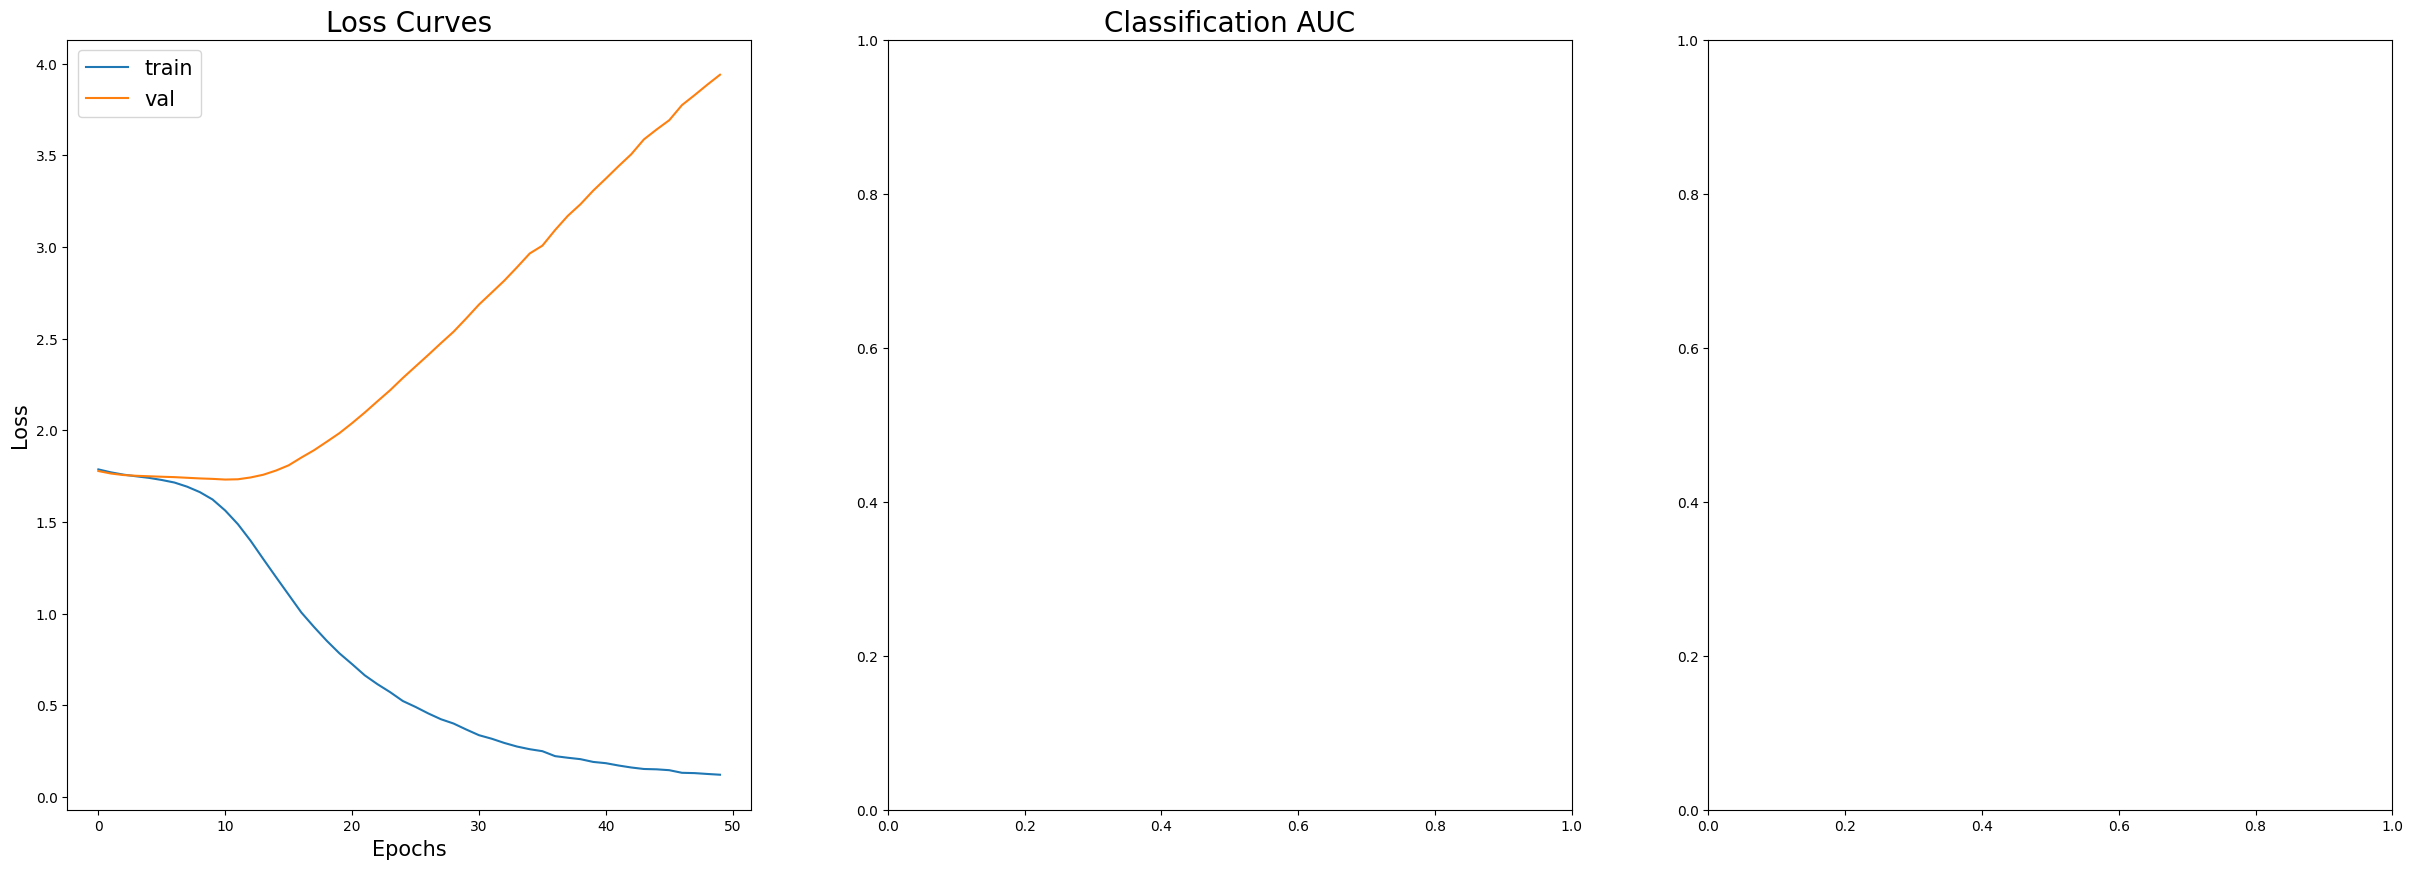

In [69]:
summarize_diagnostics(history)

In [ ]:
testLoss, testAcc, testAUC = model.evaluate(X_test,y_test, verbose=1)
print('Test loss:{:0.5f}'.format(testLoss))
print('Test accuracy:{:0.4f}'.format(testAcc))
print('Test AUC:{:0.4f}'.format(testAUC))

#(b) (10 points.) Bidirectional LSTM without pre-trained embeddings

In [34]:
X_train, y_train = load_dataset('train')
X_valid, y_valid = load_dataset('valid')
X_test, y_test = load_dataset('test')

In [35]:
# Encoding text
VOCAB_SIZE = 500
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(X_train)

vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'in', 'of', 'to', 'a', 'and', 'says', 'for',
       'that', 'is', 'on', 'has', 'have', 'percent', 'are', 'than', 'was',
       'more'], dtype='<U14')

In [36]:
vocab.shape

(500,)

In [37]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, None, 64)          32000     
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                                 
Total params: 106694 (416.77 KB)
Trainable params: 106

In [38]:
type(y_train)

list

In [39]:
type(y_train[0])

int

In [40]:
# early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10,
                   restore_best_weights=True)

# Optimizer
adam = Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy', auc])

In [41]:
# Convert categories to one-hot encoding
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

In [42]:
y_train.shape

(10240, 6)

In [43]:
X_train=np.array(X_train)
X_valid=np.array(X_valid)
X_test=np.array(X_test)

In [44]:
X_train

array(['Says the Annies List political group supports third-trimester abortions on demand.',
       'When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.',
       'Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."',
       ...,
       'Says an alternative to Social Security that operates in Galveston County, Texas, has meant that participants will retire with a whole lot more money than under Social Security.',
       'On lifting the U.S. Cuban embargo and allowing travel to Cuba.',
       "The Department of Veterans Affairs has a manual out there telling our veterans stuff like, 'Are you really of value to your community?' You know, encouraging them to commit suicide."],
      dtype='<U3192')

In [45]:
# Train
history = model.fit(X_train, y_train,
                    epochs=100,
                    callbacks=[es],
                    validation_data=(X_valid, y_valid))


Epoch 1/100
320/320 [==============================] - 37s 86ms/step - loss: 1.7690 - accuracy: 0.2045 - auc_2: 0.5627 - val_loss: 1.7622 - val_accuracy: 0.1931 - val_auc_2: 0.5712
Epoch 2/100
320/320 [==============================] - 24s 74ms/step - loss: 1.7537 - accuracy: 0.2075 - auc_2: 0.5826 - val_loss: 1.7558 - val_accuracy: 0.2087 - val_auc_2: 0.5779
Epoch 3/100
320/320 [==============================] - 24s 75ms/step - loss: 1.7410 - accuracy: 0.2232 - auc_2: 0.5974 - val_loss: 1.7379 - val_accuracy: 0.2352 - val_auc_2: 0.6001
Epoch 4/100
320/320 [==============================] - 22s 68ms/step - loss: 1.7224 - accuracy: 0.2369 - auc_2: 0.6184 - val_loss: 1.7215 - val_accuracy: 0.2453 - val_auc_2: 0.6206
Epoch 5/100
320/320 [==============================] - 24s 76ms/step - loss: 1.7057 - accuracy: 0.2512 - auc_2: 0.6332 - val_loss: 1.7145 - val_accuracy: 0.2601 - val_auc_2: 0.6252
Epoch 6/100
320/320 [==============================] - 25s 78ms/step - loss: 1.6965 - accuracy:

In [49]:
def summarize_diagnostics(history, metric_names=['loss', 'auc_2', 'accuracy']):
    fig, ax = plt.subplots(1,3, figsize=(30, 10))
    # plot loss
    ax[0].set_title('Loss Curves', fontsize=20)
    ax[0].plot(history.history[metric_names[0]], label='train')
    ax[0].plot(history.history['val_' + metric_names[0]], label='val')
    ax[0].set_xlabel('Epochs', fontsize=15)
    ax[0].set_ylabel('Loss', fontsize=15)
    ax[0].legend(fontsize=15)
    # plot AUC
    ax[1].set_title('Classification AUC', fontsize=20)
    ax[1].plot(history.history[metric_names[1]], label='train')
    ax[1].plot(history.history['val_' + metric_names[1]], label='val')
    ax[1].set_xlabel('Epochs', fontsize=15)
    ax[1].set_ylabel('AUROC', fontsize=15)
    ax[1].legend(fontsize=15)
    # plot accuracy
    ax[2].set_title('Classification accuracy', fontsize=20)
    ax[2].plot(history.history[metric_names[2]], label='train')
    ax[2].plot(history.history['val_' + metric_names[2]], label='val')
    ax[2].set_xlabel('Epochs', fontsize=15)
    ax[2].set_ylabel('Accuracy', fontsize=15)
    ax[2].legend(fontsize=15)

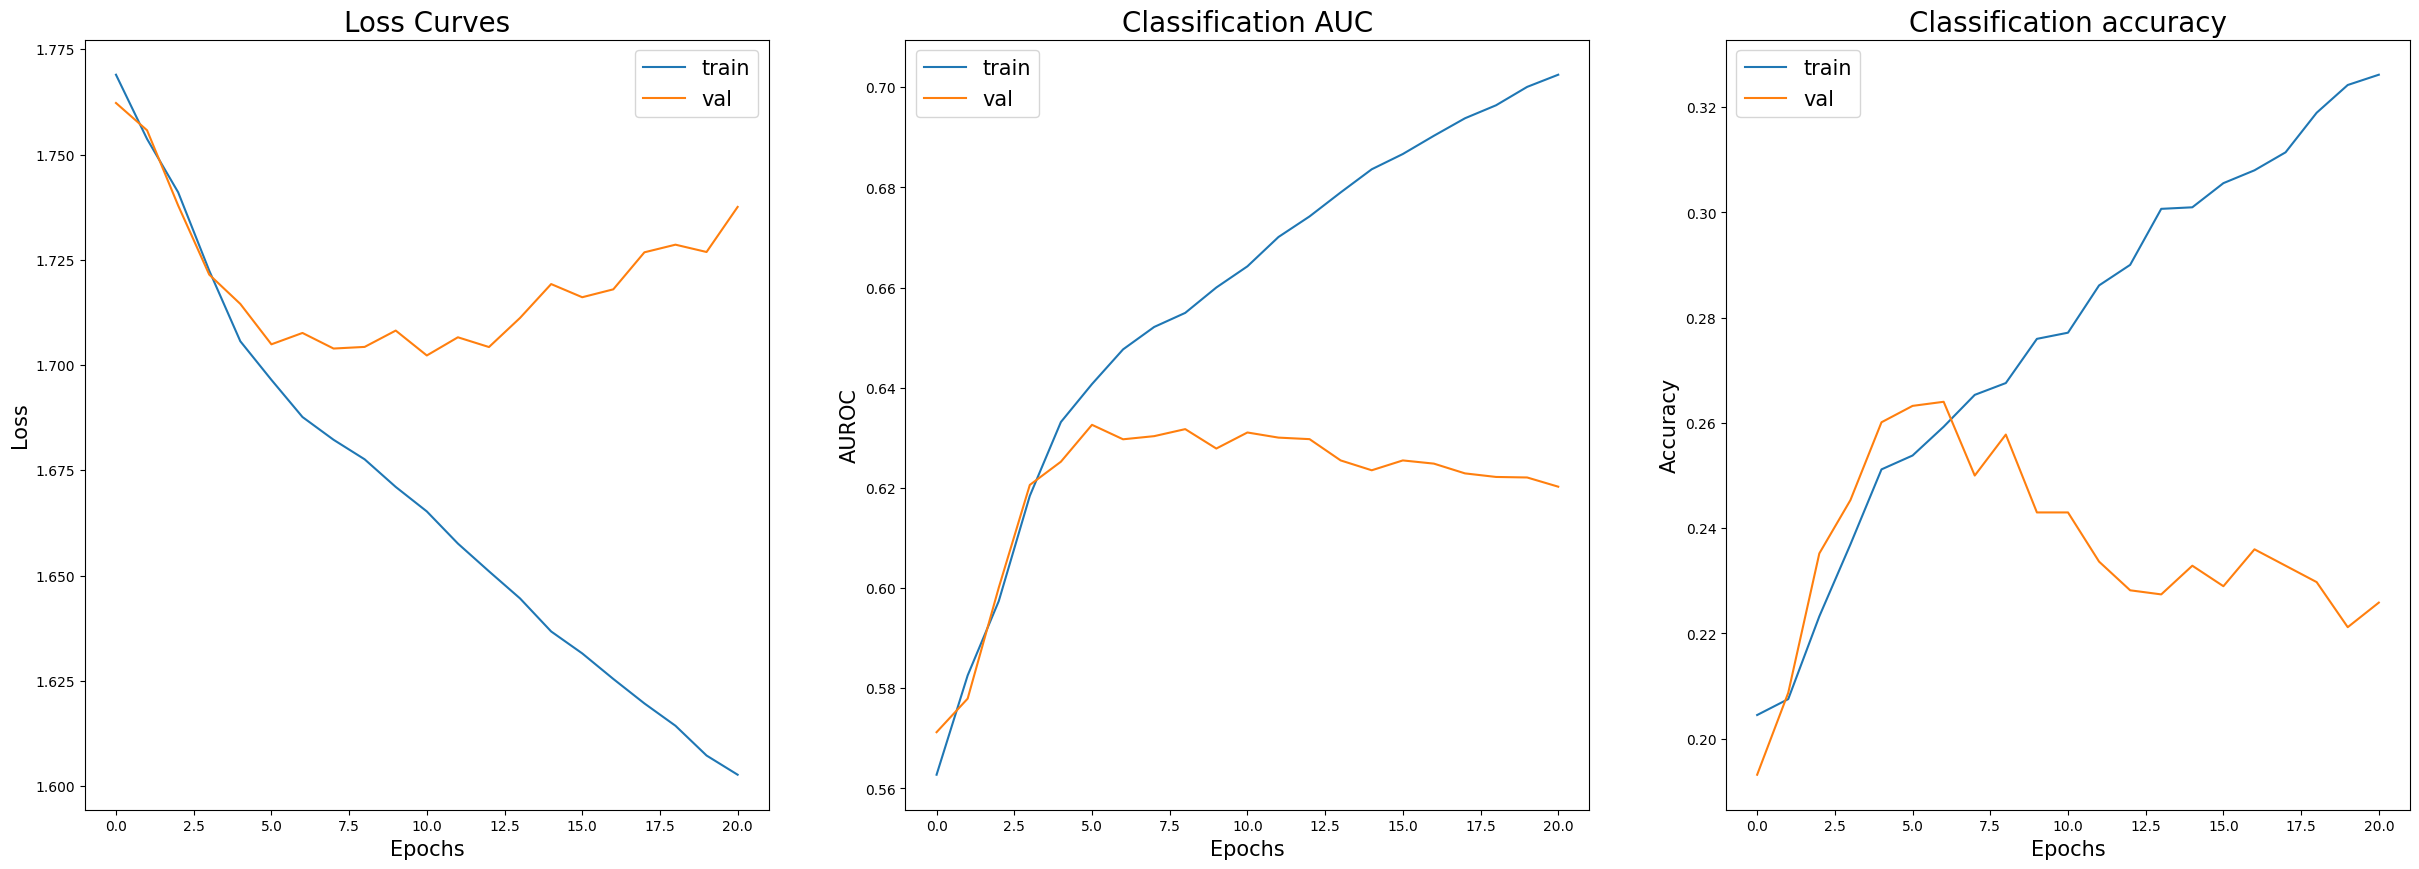

In [51]:
summarize_diagnostics(history)

In [52]:
testLoss, testAcc, testAUC = model.evaluate(X_test,y_test, verbose=1)
print('Test loss:{:0.5f}'.format(testLoss))
print('Test accuracy:{:0.4f}'.format(testAcc))
print('Test AUC:{:0.4f}'.format(testAUC))

40/40 [==============================] - 1s 20ms/step - loss: 1.7097 - accuracy: 0.2486 - auc_2: 0.6350
Test loss:1.70968
Test accuracy:0.2486
Test AUC:0.6350


#(c) (10 points.) CNN with pre-trained embeddings

In [7]:
trainX, trainY = load_dataset('train')
valX, valY = load_dataset('valid')
testX, testY = load_dataset('test')

In [8]:
trainX[1]

'When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.'

In [9]:
# Max size of vocab is set to 20000
# the max number of tokens per sample is 200
vectorizer = TextVectorization(max_tokens=20000,
                               output_sequence_length=200)

# creates a TensorFlow Dataset from a NumPy array or a tensor trainX
# groups the individual data points into batches of 128 samples each. Batching is often used to improve training efficiency and is useful when working with large datasets.
text_ds = tf.data.Dataset.from_tensor_slices(trainX).batch(128)


vectorizer.adapt(text_ds)

# Create dict to map words to indices
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [10]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-10-16 02:40:14--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-10-16 02:40:14--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-10-16 02:40:15--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [11]:
!dir

drive		   glove.6B.200d.txt  glove.6B.50d.txt	sample_data
glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip


In [12]:
# Load GloVe embeddings

path_to_glove_file = "glove.6B.100d.txt"  # Various embedding sizes are available (50, 100, 200, 300), we will use 100

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [13]:
type(embeddings_index)

dict

In [14]:
embeddings_index['we']

array([-0.17791 ,  0.62675 ,  0.4787  , -0.55295 , -0.84935 , -0.070802,
       -0.34724 ,  0.4628  ,  0.12611 , -0.24875 ,  0.46881 ,  0.083636,
        0.56065 , -0.21931 ,  0.015561, -0.55806 , -0.20738 ,  0.9123  ,
       -1.2034  ,  0.30115 ,  0.46676 ,  0.483   , -0.10204 , -0.56799 ,
       -0.027126,  0.40567 , -0.14058 , -0.55485 ,  0.094588, -0.62213 ,
       -0.30343 ,  0.60639 ,  0.049799,  0.22204 ,  0.48549 ,  0.17629 ,
       -0.090535,  0.53705 ,  0.2755  , -0.78827 , -0.70953 , -0.16678 ,
        0.11206 , -0.48491 , -0.66644 ,  0.083952,  0.32885 , -0.45851 ,
       -0.37208 , -1.5315  ,  0.12994 , -0.2409  , -0.17219 ,  1.374   ,
       -0.22313 , -2.615   ,  0.35201 ,  0.33597 ,  1.6117  ,  0.92947 ,
       -0.37535 ,  0.82034 , -1.0677  , -0.45329 ,  1.2332  ,  0.23749 ,
        0.63523 ,  0.82859 , -0.1744  , -0.5853  ,  0.56339 , -0.73094 ,
        0.30815 , -1.0888  ,  0.46139 ,  0.045386, -0.17827 , -0.054054,
       -0.8831  ,  0.033935,  0.63083 , -0.19741 , 

In [15]:
len(word_index)

13419

In [31]:
# Create an embedding matrix
embedding_dim = 100                                     # This should match the dimension GloVe embeddings (e.g., 100d)
vocab_size = len(word_index)                            # define 'word_index' is a dictionary of {word:index) of our dataset

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [16]:
# Create embedding matrix for Embedding layer
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 11636 words (1783 misses)


In [32]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       ...,
       [-0.20186999,  0.33169001, -0.065188  , ...,  0.54095   ,
         0.049431  , -0.06125   ],
       [-0.40358999, -0.29326999,  0.17761   , ...,  0.33965999,
        -0.36034   , -0.61056   ],
       [ 0.15741999,  0.10787   ,  0.12029   , ..., -0.089688  ,
        -0.33746001, -0.29078001]])

In [33]:
# Create training and validation samples using indices
x_train = vectorizer(np.array([[s] for s in trainX])).numpy()
x_val = vectorizer(np.array([[s] for s in valX])).numpy()
x_test = vectorizer(np.array([[s] for s in testX])).numpy()

# Create labels
y_train = np.array(trainY)
y_val = np.array(valY)
y_test = np.array(testY)

In [19]:
y_train

array([1, 3, 4, ..., 3, 1, 0])

In [34]:
# one hot encoding
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [35]:
x_train.shape

(10240, 200)

In [36]:
y_train

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [37]:
y_val

array([[0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [38]:
x_train.shape

(10240, 200)

In [39]:
y_train.shape

(10240, 6)

In [40]:
y_val.shape

(1284, 6)

In [41]:
input_dim = vocab_size    #  vocab_size in training set
output_dim  = 100         #  Length_of_vector_for_each_word
max_length = 200          #  Maximum length of a sequence

model = Sequential()

model.add(Embedding(input_dim,
                    output_dim,
                    input_length=max_length,
                    weights=[embedding_matrix],
                    trainable=False))

model.add(Conv1D(filters=32, kernel_size=4, activation='relu'))

model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))

model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(6, activation='softmax'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 100)          1341900   
                                                                 
 conv1d_4 (Conv1D)           (None, 197, 32)           12832     
                                                                 
 conv1d_5 (Conv1D)           (None, 195, 16)           1552      
                                                                 
 dropout_2 (Dropout)         (None, 195, 16)           0         
                                                                 
 flatten_2 (Flatten)         (None, 3120)              0         
                                                                 
 dense_2 (Dense)             (None, 6)                 18726     
                                                                 
Total params: 1375010 (5.25 MB)
Trainable params: 3311

In [45]:
## create model
model_glove = Sequential()
model_glove.add(Embedding(input_dim,
                    output_dim,
                    input_length=max_length,
                    weights=[embedding_matrix],
                    trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data


In [49]:
# early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10,
                   restore_best_weights=True)
# Optimizer
adam = Adam(learning_rate=0.0001)

model.compile(loss="categorical_crossentropy",
              optimizer=adam,
              metrics=["accuracy", auc])

# Train
history = model.fit(x_train, y_train,
                    batch_size = 128,
                    epochs = 200,
                    callbacks = [es],
                    validation_data = (x_val, y_val)
                    )

Epoch 1/200
80/80 [==============================] - 5s 47ms/step - loss: 1.7802 - accuracy: 0.1932 - auc: 0.5486 - val_loss: 1.7642 - val_accuracy: 0.2025 - val_auc: 0.5738
Epoch 2/200
80/80 [==============================] - 5s 68ms/step - loss: 1.7574 - accuracy: 0.2152 - auc: 0.5793 - val_loss: 1.7605 - val_accuracy: 0.2072 - val_auc: 0.5765
Epoch 3/200
80/80 [==============================] - 3s 43ms/step - loss: 1.7528 - accuracy: 0.2200 - auc: 0.5849 - val_loss: 1.7576 - val_accuracy: 0.2181 - val_auc: 0.5818
Epoch 4/200
80/80 [==============================] - 3s 41ms/step - loss: 1.7480 - accuracy: 0.2257 - auc: 0.5917 - val_loss: 1.7546 - val_accuracy: 0.2196 - val_auc: 0.5866
Epoch 5/200
80/80 [==============================] - 4s 51ms/step - loss: 1.7449 - accuracy: 0.2266 - auc: 0.5965 - val_loss: 1.7536 - val_accuracy: 0.2204 - val_auc: 0.5881
Epoch 6/200
80/80 [==============================] - 4s 46ms/step - loss: 1.7399 - accuracy: 0.2327 - auc: 0.6036 - val_loss: 1.74

In [55]:
def summarize_diagnostics(history, metric_names=['loss', 'auc', 'accuracy']):
    fig, ax = plt.subplots(1,3, figsize=(30, 10))
    # plot loss
    ax[0].set_title('Loss Curves', fontsize=20)
    ax[0].plot(history.history[metric_names[0]], label='train')
    ax[0].plot(history.history['val_' + metric_names[0]], label='val')
    ax[0].set_xlabel('Epochs', fontsize=15)
    ax[0].set_ylabel('Loss', fontsize=15)
    ax[0].legend(fontsize=15)

    # plot AUC
    ax[1].set_title('Classification AUC', fontsize=20)
    ax[1].plot(history.history[metric_names[1]], label='train')
    ax[1].plot(history.history['val_' + metric_names[1]], label='val')
    ax[1].set_xlabel('Epochs', fontsize=15)
    ax[1].set_ylabel('AUROC', fontsize=15)
    ax[1].legend(fontsize=15)

    # plot accuracy
    ax[2].set_title('Classification accuracy', fontsize=20)
    ax[2].plot(history.history[metric_names[2]], label='train')
    ax[2].plot(history.history['val_' + metric_names[2]], label='val')
    ax[2].set_xlabel('Epochs', fontsize=15)
    ax[2].set_ylabel('Accuracy', fontsize=15)
    ax[2].legend(fontsize=15)

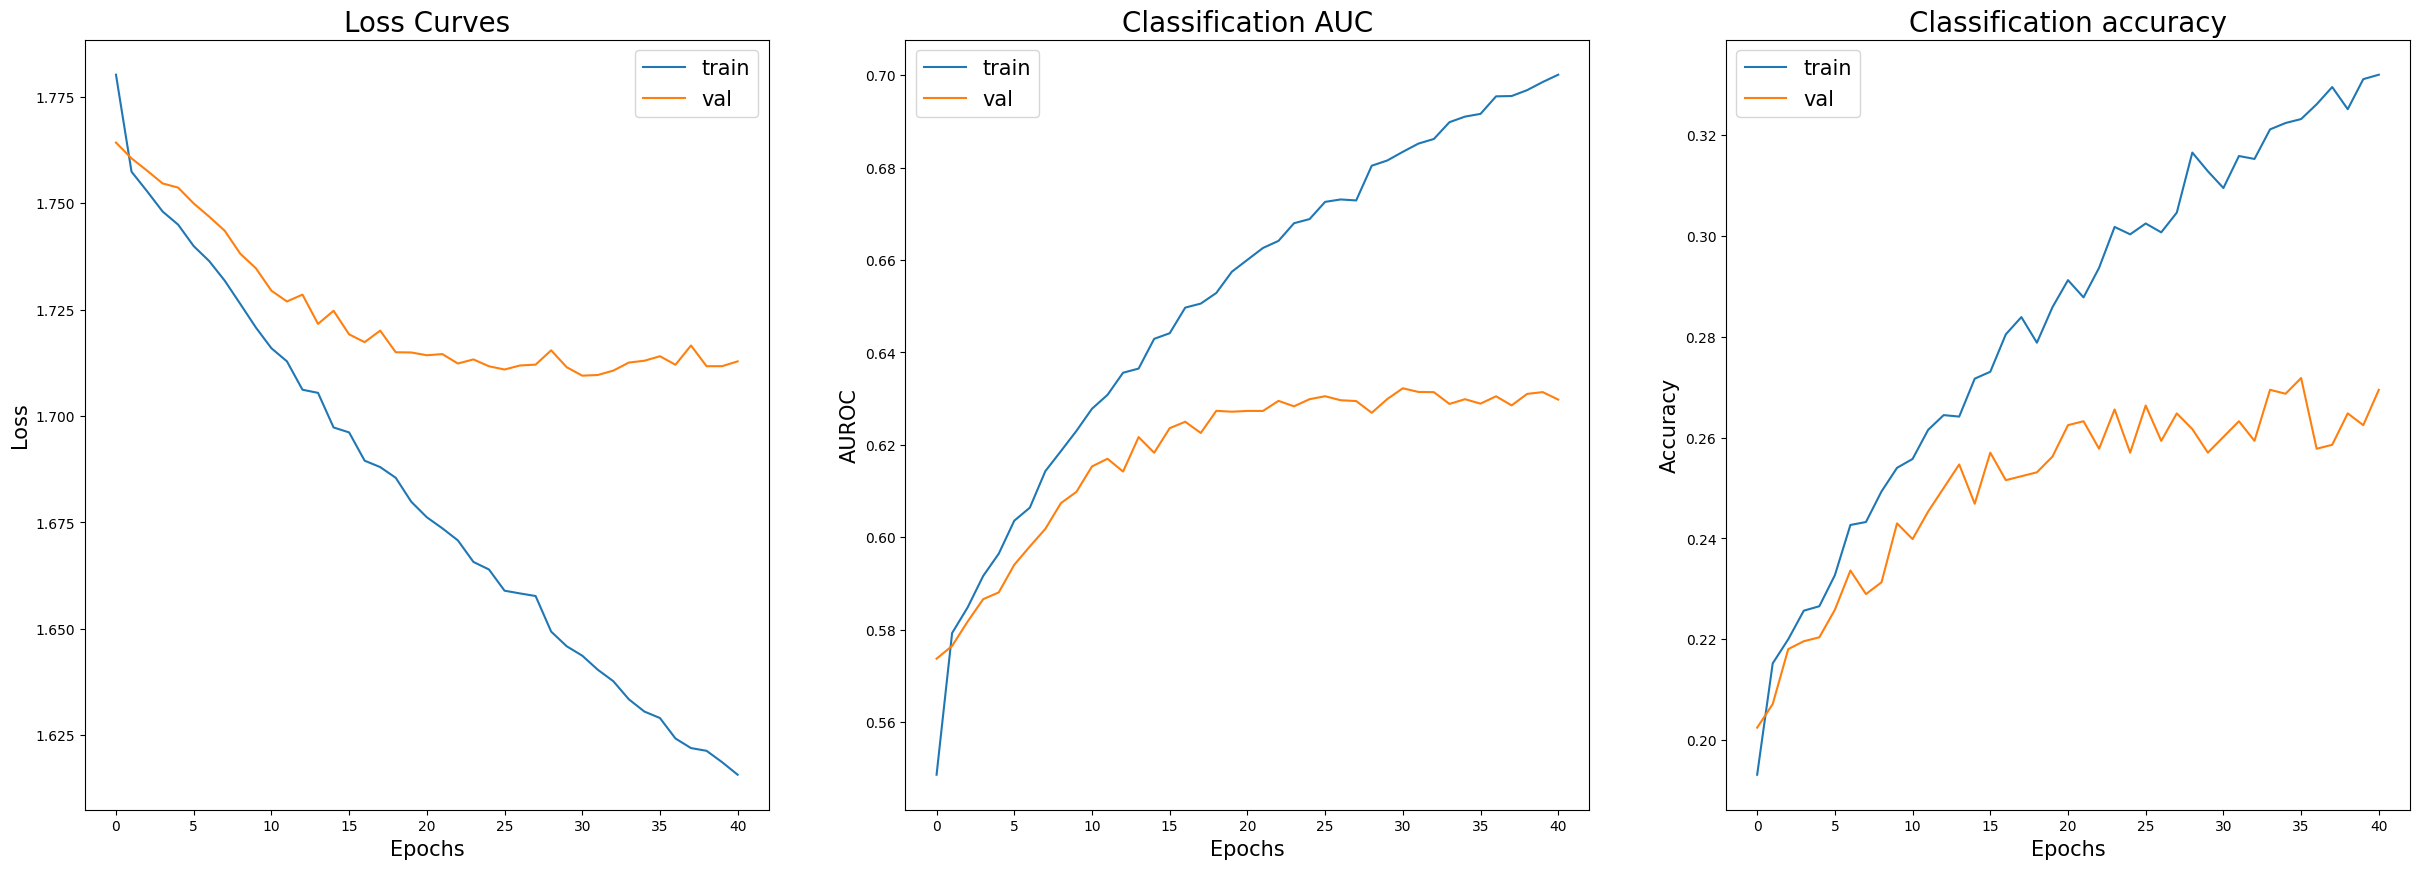

In [56]:


summarize_diagnostics(history)

In [57]:
testLoss, testAcc, testAUC = model.evaluate(x_test,y_test, verbose=1)
print('Test loss:{:0.5f}'.format(testLoss))
print('Test accuracy:{:0.4f}'.format(testAcc))
print('Test AUC:{:0.4f}'.format(testAUC))

40/40 [==============================] - 1s 11ms/step - loss: 1.7172 - accuracy: 0.2612 - auc: 0.6297
Test loss:1.71717
Test accuracy:0.2612
Test AUC:0.6297


#(d) (10 points.) Bidirectional LSTM with pre-trained embeddings

In [298]:
# loading the data
trainX, trainY = load_dataset('train')
valX, valY = load_dataset('valid')
testX, testY = load_dataset('test')

In [299]:
# Create training and validation samples using indices
x_train = vectorizer(np.array([[s] for s in trainX])).numpy()
x_val = vectorizer(np.array([[s] for s in valX])).numpy()
x_test = vectorizer(np.array([[s] for s in testX])).numpy()

# Create labels
y_train = np.array(trainY)
y_val = np.array(valY)
y_test = np.array(testY)

In [301]:
# one hot encoding
y_train = to_categorical(y_train)
y_valid = to_categorical(y_val)
y_test = to_categorical(y_test)

In [302]:
y_valid

array([[0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [305]:
y_val

array([2, 0, 1, ..., 5, 1, 2])

In [93]:
# Create embedding layer
embedding_layer = Embedding( num_tokens,
                            embedding_dim,
                             embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                             trainable = False
                             )

In [ ]:

# Load pre-trained GloVe word embeddings
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [ ]:
# Create an embedding matrix
embedding_dim = 100                                     # This should match the dimension GloVe embeddings (e.g., 100d)
vocab_size = len(word_index)                            # define 'word_index' is a dictionary of {word:index) of our dataset

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [352]:
# Create the Bidirectional LSTM model

max_sequence_length = 200

model = tf.keras.Sequential([

    Embedding(input_dim = vocab_size,
              output_dim = embedding_dim,
              weights = [embedding_matrix],
              input_length = max_sequence_length,
              trainable = False),

    Bidirectional(LSTM(64, return_sequences=True)),

    Bidirectional(LSTM(32)),

    Dense(256, activation='relu'),
    Dropout(0.7),
    Dense(128, activation='relu'),
    Dropout(0.7),
    Dense(64, activation='relu'),
    Dropout(0.7),
    Dense(6, activation='softmax')
])
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 200, 100)          1341900   
                                                                 
 bidirectional_50 (Bidirect  (None, 200, 128)          84480     
 ional)                                                          
                                                                 
 bidirectional_51 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                                 
 dense_82 (Dense)            (None, 256)               16640     
                                                                 
 dropout_33 (Dropout)        (None, 256)               0         
                                                                 
 dense_83 (Dense)            (None, 128)             

In [353]:
# Create early stopping callback
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10,
                   restore_best_weights=True)

# Define the optimizer
adam = Adam(learning_rate=0.0001)

# Compile the model with early stopping and the defined optimizer
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy', auc ])


In [354]:
# Train
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=100,
                    callbacks=[es],
                    validation_data=(x_val, y_valid))

Epoch 1/100
160/160 [==============================] - 172s 673ms/step - loss: 1.8086 - accuracy: 0.1688 - auc_2: 0.5197 - val_loss: 1.7836 - val_accuracy: 0.1924 - val_auc_2: 0.5603
Epoch 2/100
160/160 [==============================] - 103s 647ms/step - loss: 1.7897 - accuracy: 0.1825 - auc_2: 0.5262 - val_loss: 1.7790 - val_accuracy: 0.1931 - val_auc_2: 0.5667
Epoch 3/100
160/160 [==============================] - 103s 641ms/step - loss: 1.7798 - accuracy: 0.1946 - auc_2: 0.5498 - val_loss: 1.7734 - val_accuracy: 0.1931 - val_auc_2: 0.5695
Epoch 4/100
160/160 [==============================] - 103s 647ms/step - loss: 1.7742 - accuracy: 0.2024 - auc_2: 0.5607 - val_loss: 1.7705 - val_accuracy: 0.1931 - val_auc_2: 0.5703
Epoch 5/100
160/160 [==============================] - 105s 656ms/step - loss: 1.7710 - accuracy: 0.1918 - auc_2: 0.5645 - val_loss: 1.7668 - val_accuracy: 0.1931 - val_auc_2: 0.5753
Epoch 6/100
160/160 [==============================] - 104s 649ms/step - loss: 1.7698

In [355]:
def summarize_diagnostics(history, metric_names=['loss', 'auc_2', 'accuracy']):
    fig, ax = plt.subplots(1,3, figsize=(30, 10))
    # plot loss
    ax[0].set_title('Loss Curves', fontsize=20)
    ax[0].plot(history.history[metric_names[0]], label='train')
    ax[0].plot(history.history['val_' + metric_names[0]], label='val')
    ax[0].set_xlabel('Epochs', fontsize=15)
    ax[0].set_ylabel('Loss', fontsize=15)
    ax[0].legend(fontsize=15)

    # plot AUC
    ax[1].set_title('Classification AUC', fontsize=20)
    ax[1].plot(history.history[metric_names[1]], label='train')
    ax[1].plot(history.history['val_' + metric_names[1]], label='val')
    ax[1].set_xlabel('Epochs', fontsize=15)
    ax[1].set_ylabel('AUROC', fontsize=15)
    ax[1].legend(fontsize=15)

    # plot accuracy
    ax[2].set_title('Classification accuracy', fontsize=20)
    ax[2].plot(history.history[metric_names[2]], label='train')
    ax[2].plot(history.history['val_' + metric_names[2]], label='val')
    ax[2].set_xlabel('Epochs', fontsize=15)
    ax[2].set_ylabel('Accuracy', fontsize=15)
    ax[2].legend(fontsize=15)

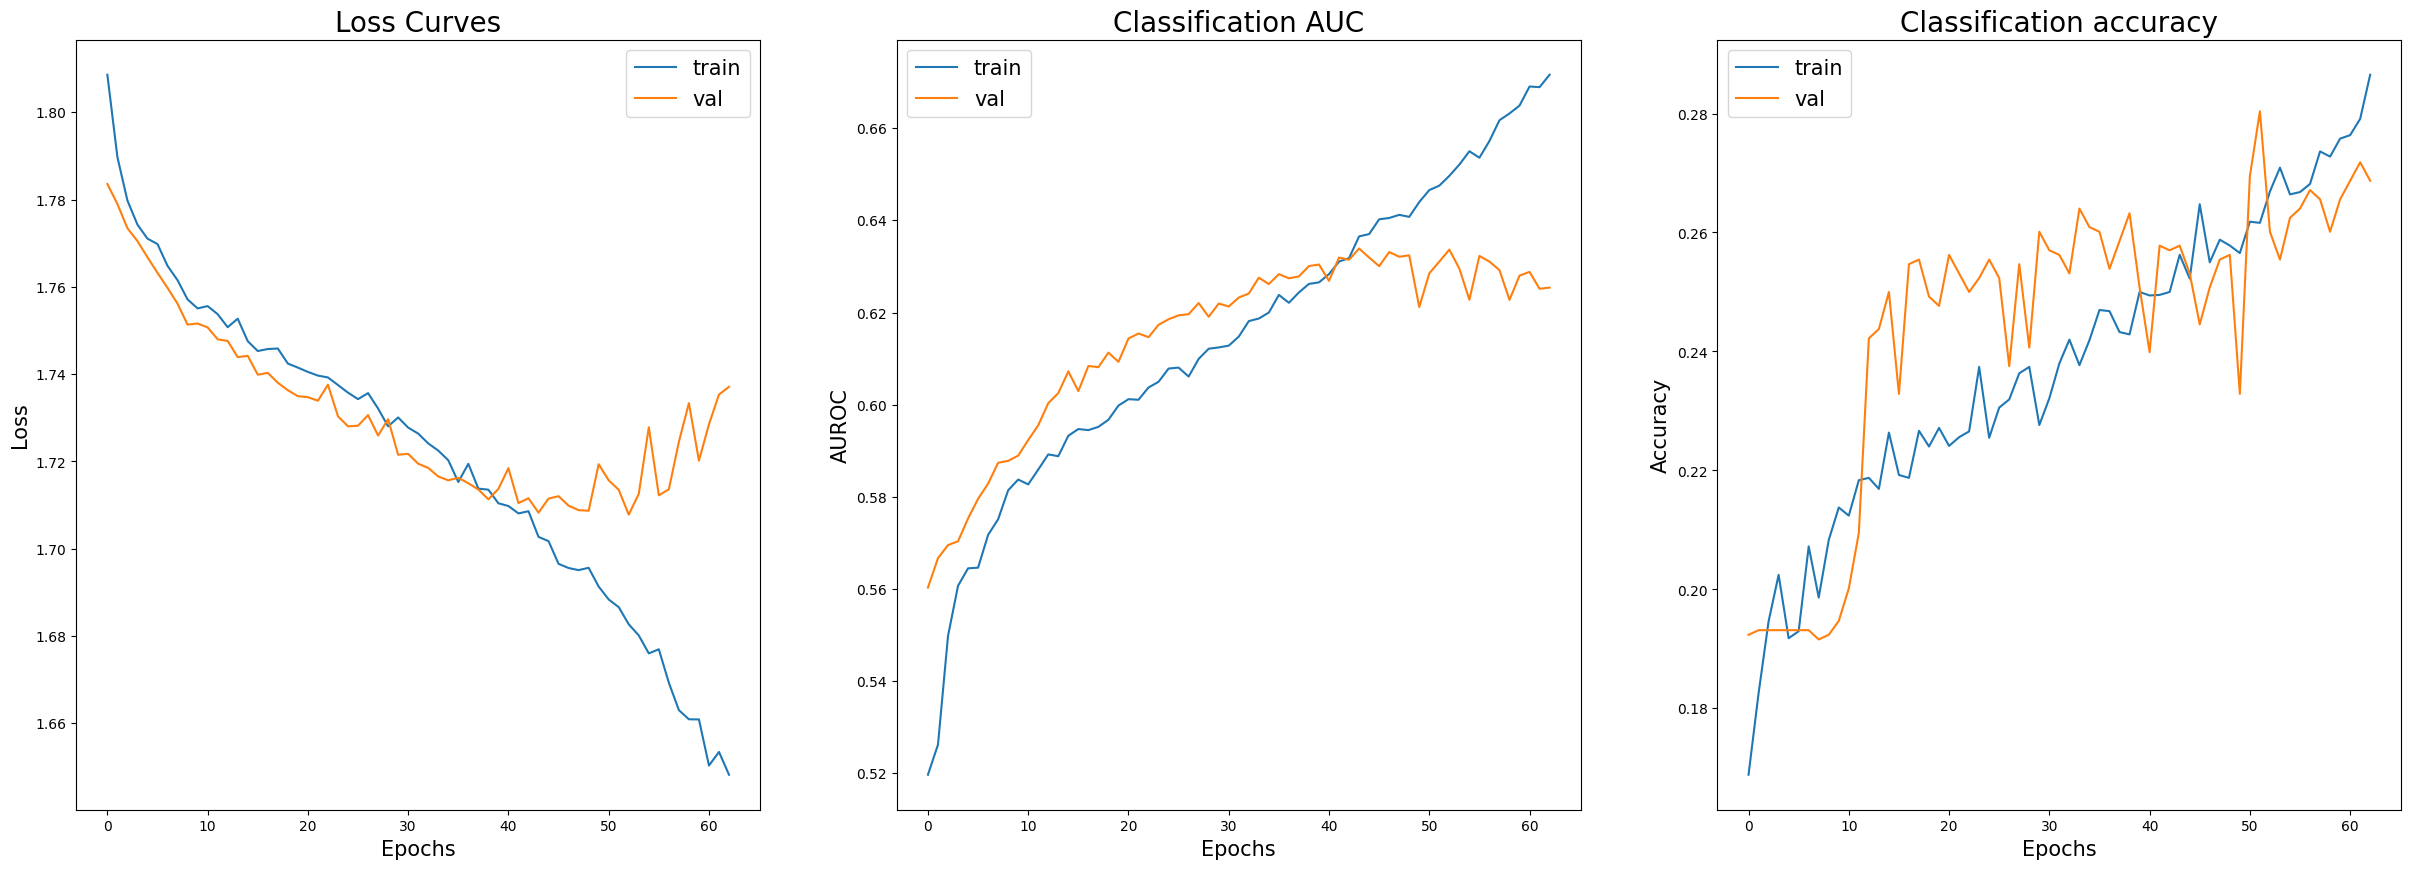

In [356]:
summarize_diagnostics(history)

In [357]:
testLoss, testAcc, testAUC = model.evaluate(x_test,y_test, verbose=1)
print('Test loss:{:0.5f}'.format(testLoss))
print('Test accuracy:{:0.4f}'.format(testAcc))
print('Test AUC:{:0.4f}'.format(testAUC))

40/40 [==============================] - 6s 146ms/step - loss: 1.7187 - accuracy: 0.2478 - auc_2: 0.6225
Test loss:1.71873
Test accuracy:0.2478
Test AUC:0.6225
